In [144]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from ipynb.fs.full.datasetgenerator_sinewaves import create_dataset

In [155]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(1800, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # Two outputs for mean and log variance
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1800),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        z_params = self.encoder(x)
        mu, logvar = z_params.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [156]:
# Hyperparameters
latent_dim = 32
batch_size = 64
learning_rate = 1e-3
epochs = 500

In [157]:
# Create the VAE model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [158]:
# Generate dataset using the provided function
number_of_generated_samples: int = 10_000
number_of_survive_samples: int = 1000
selected_designs_masked, fitness_values = create_dataset(number_of_survive_samples, number_of_generated_samples)
data = torch.FloatTensor(selected_designs_masked).view(-1, 1800).to(device)  # Reshape to 1D tensor
data = data / 3.0

In [159]:
# Create DataLoader
dataset = TensorDataset(data)
print(f" dataset: {dataset}")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

 dataset: <torch.utils.data.dataset.TensorDataset object at 0x7f29394bc5e0>


In [160]:
# Training loop
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')
    reconstruction_loss = BCE(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print(f" kl_div: {kl_divergence} recon_loss: {reconstruction_loss}")
    return reconstruction_loss + kl_divergence

for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    #print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss / len(dataset)}")


In [161]:
# Generate samples from the VAE
with torch.no_grad():
    z = torch.randn(number_of_survive_samples, latent_dim).to(device)
    generated_samples = model.decoder(z).cpu().view(-1, 30, 30)

In [162]:
# Evaluate the trained model
model.eval()  # Set the model to evaluation mode
total_reconstruction_loss = 0

with torch.no_grad():
    for batch in dataloader:
        batch = batch[0]
        recon_batch, _, _ = model(batch)
        reconstruction_loss = vae_loss(recon_batch, batch, _, _)
        total_reconstruction_loss += reconstruction_loss.item()

average_reconstruction_loss = total_reconstruction_loss / len(dataset)
print(f"Average Reconstruction Loss: {average_reconstruction_loss}")

Average Reconstruction Loss: -4787.63028125


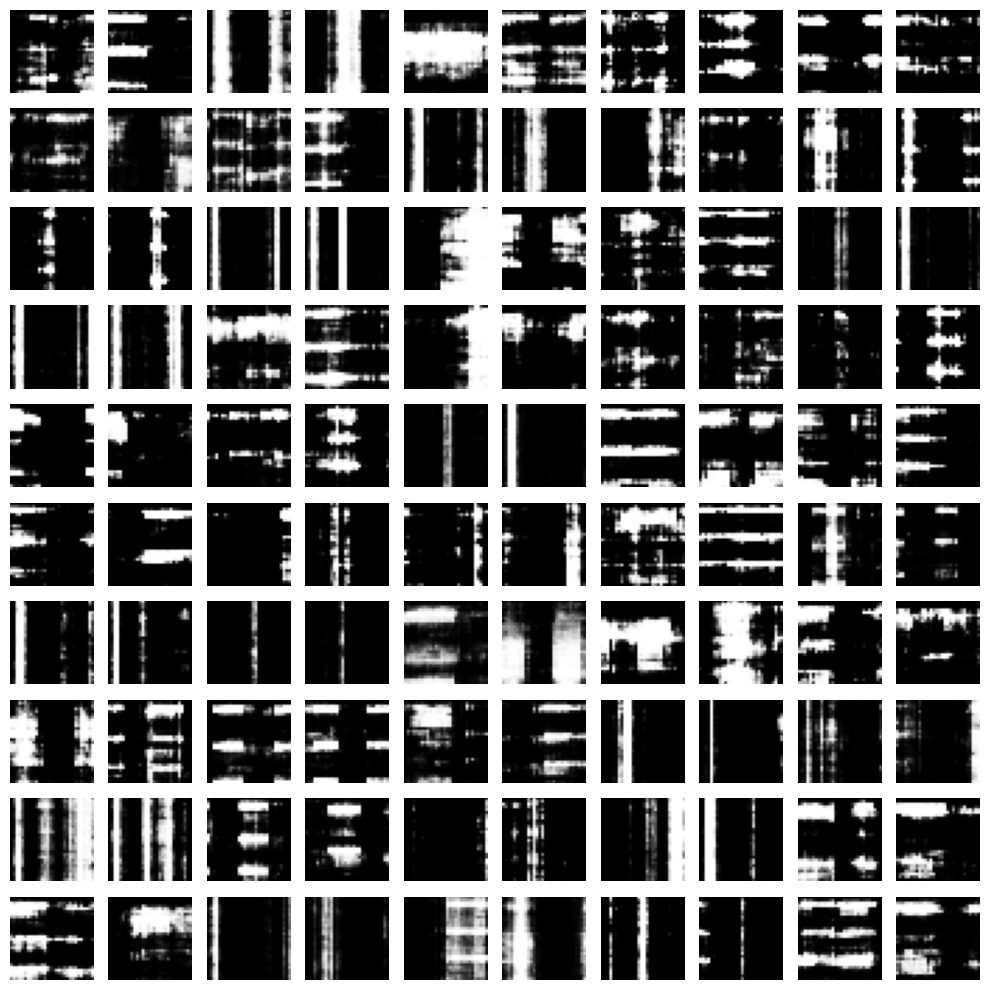

In [163]:
# Plot the generated samples
num_plots_per_axis = 10
fig, axs = plt.subplots(num_plots_per_axis, num_plots_per_axis, figsize=(10, 10))
for i in range(num_plots_per_axis):
    for j in range(num_plots_per_axis):
        axs[i, j].imshow(generated_samples[num_plots_per_axis * i + j], cmap='gray', vmin=0, vmax=1)
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()